<a href="https://colab.research.google.com/github/fajemila/zindi-Wheat-g-Challenge/blob/master/CGIAR_STARTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import requests
import requests, zipfile

#the url and auth_value from the website 
url = "https://api.zindi.africa/v1/competitions/cgiar-wheat-growth-stage-challenge/files/Images.zip"
myobj = {'auth_token': 'wLQWzzvtzxnYfG5kVe6CLxfg'} #use your own

x = requests.post(url, data = myobj,stream=True)
target_path = 'image.zip'


In [ ]:
handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq /content/image.zip

replace Images/GsXvEpbw.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Images/GsXvEpbw.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]
error:  invalid response [[A]]
replace Images/GsXvEpbw.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!pip install efficientnet_pytorch torchtoolbox
!pip install resnet_pytorch

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=6862595fefec89a997b25bfbcc727dd2b80effa8a972b79b8e4371ac6a6697c0
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [1]:
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from resnet_pytorch import ResNet
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score
import torchvision
torch.manual_seed(47)
np.random.seed(47)
%matplotlib inline

In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/cgiar/Train.csv')
submission = pd.read_csv('/content/drive/My Drive/cgiar/SampleSubmission.csv')

In [3]:
data.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


In [4]:
submission.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [5]:
submission.shape

(3558, 2)

In [6]:
data.growth_stage.value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

In [7]:
data.label_quality.value_counts()

1    7839
2    2856
Name: label_quality, dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


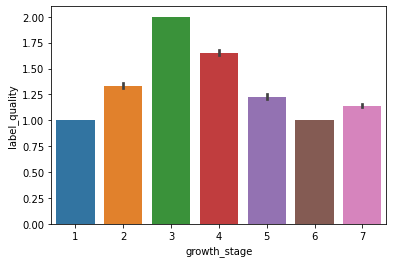

In [8]:
import seaborn as sns
sns.barplot(x='growth_stage',y='label_quality',data=data)

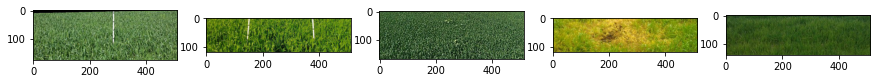

In [9]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize=(15,10))

for i,idx in enumerate(data[data['growth_stage'] == 4]['UID'][-5:]):
    path = '/content/Images/' + idx + '.jpeg'
    ax[i].imshow(img.imread(path))

248832
196608
(256, 256, 3)
<class 'numpy.ndarray'>
278016
196608
(256, 256, 3)
<class 'numpy.ndarray'>
236544
196608
(256, 256, 3)
<class 'numpy.ndarray'>
264192
196608
(256, 256, 3)
<class 'numpy.ndarray'>
296448
196608
(256, 256, 3)
<class 'numpy.ndarray'>


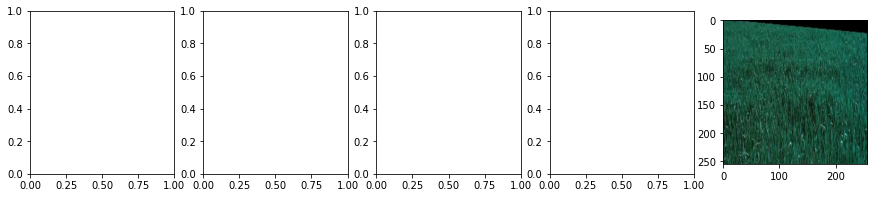

In [10]:
from PIL import Image
import cv2
plt.subplots(1,5,figsize=(15,3))
for ind in data[data['growth_stage'] == 5]['UID'][-5:]:
    pathe = '/content/Images/' + ind + '.jpeg'
    
    imgr = cv2.imread(pathe)
    print(imgr.size)
    imgr = cv2.resize(imgr,dsize=(256,256))

    print(imgr.size)
    print(imgr.shape)#oe)
    #imgr = transforms.ToTensor(imgr)
    print(type(imgr))
    plt.imshow(imgr)

In [11]:
class CGIARGWHEAT(Dataset):
    def __init__(self, data, traindata = None, transform = None):
        super().__init__()
        self.data = data
        self.path = path
        self.transform = transform
        self.traindata = traindata
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path = '/content/Images/' + self.data.iloc[index]['UID'] + '.jpeg'
        #image = img
        image = cv2.imread(img_path)
        image = torch.Tensor(cv2.resize(image,dsize= (299,299))).permute(2,0,1)
        # image = image[0:224, 0:224]
        if self.transform:#s:
            image = self.transform(image)#s(image)
            
        if self.traindata:
            label = self.data.iloc[index]['growth_stage']
            return image,label
        else:
            return image

In [12]:
train, valid_data = train_test_split(data, stratify=data.growth_stage,test_size=0.2)

In [13]:
train_df = pd.merge(train,data,how='inner')
valid_df = pd.merge(valid_data,data,how='inner')

In [14]:
transform = transforms.Normalize((0.453,0.455,0.435),(0.234,0.238,0.243))

In [15]:
train_data = CGIARGWHEAT(data = train_df,traindata=True,transform = transform)
valid_data = CGIARGWHEAT(data = valid_df,traindata = True,transform = transform)
test_data = CGIARGWHEAT(data = submission)

In [16]:
num_classes = 7
batch_size = 25
learning_rate = 0.0001
num_epochs = 10

In [17]:
train_loader = DataLoader(train_data,batch_size=batch_size)
valid_loader = DataLoader(valid_data,batch_size=batch_size)
test_laoder = DataLoader(test_data,batch_size=batch_size)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [19]:
model_ft = torchvision.models.resnet18(pretrained=True)#lr=e4,2epoch 92, lr=e5,4epoch93
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model_ft = torchvision.models.alexnet(pretrained=True)#lr=e4,4epoch 90.9 e5 86
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
model_ft.to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model_ft = torchvision.models.vgg11_bn(pretrained=True)#lr=e4,1epo ch 91 e5 93.5
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
model_ft.to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model_ft = torchvision.models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)
model_ft.to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
# our dataloader is ready.
# let's make model

# building blocks for mobilenet.
# name Conv and Conv_dw are following the terms used in mobilenet paper (https://arxiv.org/pdf/1704.04861.pdf)

class Conv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        
    def forward(self, input):
        return self.layers(input)
    
class Conv_dw_Conv(nn.Module):
    # Conv dw layer followed by Conv layer.
    # implemented this way since every conv dw layer is followed by conv layer with kernel size 1, stride 1 with some out_channel
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(in_channel, in_channel, kernel_size, stride, padding, bias=False, groups=in_channel),
                nn.BatchNorm2d(in_channel),
                nn.ReLU(inplace=True),
                Conv(in_channel, out_channel, kernel_size=1, stride=1, padding=0)
            )
        
    def forward(self, input):
        return self.layers(input)
    
    
class MobileNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.model = nn.Sequential(
                Conv(3, 32, stride=2),
                Conv_dw_Conv(32, 64, kernel_size=3, stride=1),
                Conv_dw_Conv(64, 128, kernel_size=3, stride=2),
                Conv_dw_Conv(128, 128, kernel_size=3, stride=1),
                Conv_dw_Conv(128, 256, kernel_size=3, stride=2),
                Conv_dw_Conv(256, 256, kernel_size=3, stride=1),
                Conv_dw_Conv(256, 512, kernel_size=3, stride=2),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 1024, kernel_size=3, stride=2),
                Conv_dw_Conv(1024, 1024, kernel_size=3, stride=1)
        )
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, input):
        x = self.model(input)
        x = self.avg_pool(x)
        x = x.view(-1, 1024)
        out = self.fc(x)
        return out

In [ ]:
model_ft = MobileNet(1)
model_ft.to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [22]:
train_losses = []
valid_losses = []
for epoch in range(1, num_epochs + 1):
    y_true = []
    y_pred = []
    train_loss = 0.0
    valid_loss = 0.0
    # scheduler.step()
    model_ft.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model_ft(data)
        # target = target.unsqueeze(1).type_as(output)
        loss = criterion(output, target)

RuntimeError: ignored

In [ ]:
target.unsqueeze(1)

In [24]:
output

RuntimeError: ignored

In [21]:
target.dtype

torch.int64

In [ ]:
train_losses = []
valid_losses = []
for epoch in range(1, num_epochs + 1):
    y_true = []
    y_pred = []
    train_loss = 0.0
    valid_loss = 0.0
    # scheduler.step()
    model_ft.train()
    for data, target in train_loader:
        data = torch.tensor(data, device=device, dtype=torch.float32)
        target = torch.tensor(target, device=device, dtype=torch.float32)
        optimizer.zero_grad()
        output = model_ft(data)
        target = target.unsqueeze(1).type_as(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
    model_ft.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data = torch.tensor(data, device=device, dtype=torch.float32)
            target = torch.tensor(target, device=device, dtype=torch.float32)
            target = target.unsqueeze(1).type_as(output)
            output = model_ft(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # print-training/validation-statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use

Epoch: 1 	Training Loss: 3.461461 	Validation Loss: 2.849192
Epoch: 2 	Training Loss: 2.458690 	Validation Loss: 2.310410
Epoch: 3 	Training Loss: 2.116797 	Validation Loss: 2.240581
Epoch: 4 	Training Loss: 1.739648 	Validation Loss: 2.251011
Epoch: 5 	Training Loss: 1.065568 	Validation Loss: 2.292348


In [23]:
 loss = nn.CrossEntropyLoss()


In [24]:
target = torch.empty(3, dtype=torch.long).random_(5)
target

tensor([0, 2, 2])

In [25]:
input = torch.randn(3, 5, requires_grad=True)
input

tensor([[-0.1304,  2.0132,  2.5291,  1.5805, -0.0435],
        [-0.8022, -0.0723, -3.0012, -0.0636,  1.3841],
        [-0.6424, -0.3733,  0.6781,  0.7314, -0.5286]], requires_grad=True)

In [ ]:
>>> output = loss(input, target)
>>> output.backward()

In [ ]:
train_loss

5.062798955162979

In [ ]:
target

('y0em5p4n',
 'ac9MfLD6',
 'LR7It1nK',
 'iGteAfzq',
 'ftJT9RdO',
 'WOTCmI1A',
 'jzaelHxw',
 'gDCJrwa3',
 'D9I5NUhb',
 'lNjGreM2',
 'VfLdFBaJ',
 'GAxHNMba')